# Rubric 1: 
### Are all required files submitted?

This submission includes a model.py file, drive.py, udacityModel12.h5 a writeup report and video.mp4.

* __ Code __ : all the code that is required to load the data and train a successful deep network is in this notebook. Instead of putting my code in model.py, I have used jupyter notebook, since it help me to quickly modify section of a code and run it. This was, completing my project on jupyter took lesser amount of time. Please __ DO NOT __ use code from model.py to train a model.
* __ drive.py __: drive.py has been modified a little, because model was attempted to be trained in many ways. Thus many  improvements were performed since the beginning.
* __ model.h5 __ : the file used to make the final video of car driving autonomously uses __udacityModel12.h5__
* __ video.mp4 __ : final video file of autonomous driving in simulator can be found [here](https://youtu.be/YLpbEgAxIP4). Video from images generated from drive.py can be found as __ autonomousDriving.mp4 __.
* __ writeup __ : project report can be found in __writeup/Solution.md__

# Rubric 2: 
### Is the code functional?

This code is fully functional and final successfully trained deep network is produced by code in this repository.

To train a model run all the cell of this notebook before Rubric 11. Do __ NOT __ code in model.py to train a model.

How to run car in simulator from model, is explained in Rubric 11 cells.


# Rubric 3:

### Is the code usable and readable?

My code is in the jupyter notebook and NOT in model.py. Because Jupyter notebook's ability to run one section at at time came in very handy to quickly develop my project.

I have commented whole code as needed.

#### Generators:
Generators turned out to be essential for training this model, because I didn't have access to a machine with lots of main memory or processing power. So, generating small chunks of data and loading only that much proved to be absolute necessity.

Not only in this project, I think generators are very useful tool to train models on large data.

# Rubric 4: 

### Has an appropriate model architecture been employed for the task?

I have tried to closely follow architecutre of NVidia model.

Before settling on NVidia model, I experimented with different architectures and colour spaces. Small trainnig time was important because I have a normal computer (with i7 processor and 8 GB RAM, without any graphics card), which caused me to resize input images to neural network to (200, 66) rather than the default (320, 160).

Also, unlike the research paper published by NVidia group, I have used RGB channels, instead of YUV channels.

I have normalized the images so that input numbers are between -0.5 and +0.5

Following is the diagram of [NVidia model](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) (taken from the research paper itself).

<img src="nVidia_model.png" width=400 height =400/>

# Rubric 8:

### Is the solution design documented?

Initially I started with a deep network, which looks like NVidia model, however, it had about 10 million parameters. I expected that such a large network will do well because the input data has variety. However, such a model was too slow to train.

Then I created a model as close to NVidia model as possible. Same number of convolutional and dense layers and same convolution parameters. This model was able to make the car turn after second turn in simulator. However, after second turn, it was not able to make the third sharp-right turn. I decided I needed better data.

The data I had manually collected did not have high steering angles, i.e. it was collected while driving completely straight. So, I decided to give data provided by Udacity a try. And only after two iteration of training (one training session had many epochs), my model was able to turn car quite accurately (without going into lake or bumping in railings) started to give fair results.

One of the best thing about Keras, (after enabling user to create deep networks very quickly) is the ability to save the model weights after each iteration. This turned out to be very useful. Because, I don't know exactly how many epochs should be chosen. Allowing me to save model after each epoch allowed me to choose best model from all the iterations. I chose the model file with best (i.e. lowest) validation loss.


In [6]:
import argparse
import os
import csv
import cv2
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Lambda, Dense, Flatten, Cropping2D, Convolution2D, Dropout
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, Callback

import matplotlib.pyplot as plt

from myModels import *

### Helping Functions:

In [7]:
def getCsvLines(path):
    # read image paths and corresponding steering angles
    samples =[]
    firstLine = True
    with open(path) as csvfile:
        reader = csv.reader(csvfile)
        for i_line in reader:
            if firstLine==True:
                firstLine=False
            else:
                samples.append(i_line)
    return samples


def prepareTrainingData(path, useAllCameraImages=False, cameraCorrectionFactor = 0.15):
    imagePaths = []
    angles = []
    camera_angle_factor = [0,+1,-1]

    samplesLines = getCsvLines(path)
    if useAllCameraImages:
        imagesToUse = 3
    else:
        imagesToUse = 1

    for i_line in samplesLines:

        for i in range(imagesToUse):
            i_imagePath = i_line[i].split('/')[-1]
            imagePaths.append(i_imagePath)
            i_angle = float(i_line[3])+cameraCorrectionFactor*camera_angle_factor[i]
            angles.append(i_angle)        

    samples = list(zip(imagePaths, angles))
    return samples

def generator(samples, dataDir, batch_size=32,color_space='RGB', useFlipImages=False):
    num_samples = len(samples)
    baseDir = dataDir +'/IMG/'

    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images, angles = [], []
            for i_imagePath, i_angle in batch_samples:
                
                #images.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))
                i_image = cv2.imread(baseDir+i_imagePath)
                #print(name)
                # crop the image
                i_image = i_image[51:141,:]
                
                # resize the image to 66 by 200
                i_image = cv2.resize(i_image, (200, 66))
                
                if color_space == 'RGB':
                    i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2RGB)
                elif color_space == 'HSV':
                    i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2HSV)
                elif color_space == 'LUV':
                    i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2LUV)
                elif color_space == 'HLS':
                    i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2HLS)
                elif color_space == 'YUV':
                    i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2YUV)
                elif color_space == 'YCrCb':
                    i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2YCrCb)
                        
                images.append(i_image)
                # add steering angle according to which camera it came from i.e. center, left or right
                angles.append(i_angle)
                
                if useFlipImages:
                    # add flipped images also
                    images.append(np.fliplr(i_image))
                    angles.append(-i_angle)


                # trim image to only see section with road
                X_train = np.array(images)
                y_train = np.array(angles)

                #print(X_train.size,y_train.size)
                yield sklearn.utils.shuffle(X_train, y_train)


# Rubric 5:

### Has an attempt been made to reduce overfitting of the model?

I experimented with drop out layers and l2 regularizers, and in the end decided to use l2 regularizers only.

Training and validation set have been divided into 80% and 20% ratio.

Following cell contains two candidate models, out of which, I have used __ smallerNVidiaModel() __ to create model, which uses L2 regulizers.

In [8]:
# replicate nVidia pipeline
def createNVidiaModel(activation_function='elu', dropOutRate=0.0, inputImageShape=(66,200,3)):

    model = Sequential()

    # add normalization and cropping layers
    #model.add(Cropping2D(cropping=((50,20),(0,0)), input_shape = (160,320,3)))

    # resize images to 66*200
    #    model.add(Lambda(lambda x:
    # normalise the input images so that input values to NN varies from -0.5 to 0.5    
    model.add(Lambda(lambda x: x/255-0.5, input_shape = inputImageShape))
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation=activation_function))
    model.add(Dropout(dropOutRate))    
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation=activation_function))
    model.add(Dropout(dropOutRate))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation=activation_function))
    model.add(Dropout(dropOutRate))
    model.add(Convolution2D(64,3,3, subsample=(1,1), activation=activation_function))
    model.add(Dropout(dropOutRate))
    model.add(Convolution2D(64,3,3, subsample=(1,1), activation=activation_function))
    model.add(Dropout(dropOutRate))
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))

    return model


def smallerNVidiaModel(activation_function='elu', dropOutRate=0.0, inputImageShape=(66,200,3)):

    model = Sequential()

    # add normalization and cropping layers
    #model.add(Cropping2D(cropping=((50,20),(0,0)), input_shape = (160,320,3)))

    # resize images to 66*200
    #    model.add(Lambda(lambda x:
    # normalise the input images so that input values to NN varies from -0.5 to 0.5    
    model.add(Lambda(lambda x: x/255-0.5, input_shape = inputImageShape))
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation=activation_function, W_regularizer=l2(0.001)))
    model.add(Dropout(dropOutRate))    
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation=activation_function, W_regularizer=l2(0.001)))
    model.add(Dropout(dropOutRate))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation=activation_function, W_regularizer=l2(0.001)))
    model.add(Dropout(dropOutRate))
    model.add(Convolution2D(64,3,3, subsample=(1,1), activation=activation_function, W_regularizer=l2(0.001)))
    model.add(Dropout(dropOutRate))
    model.add(Convolution2D(64,3,3, subsample=(1,1), activation=activation_function, W_regularizer=l2(0.001)))
    model.add(Dropout(dropOutRate))
    model.add(Flatten())
#    model.add(Dense(1164))
    model.add(Dense(100, W_regularizer=l2(0.001)))
    model.add(Dense(50, W_regularizer=l2(0.001)))
    model.add(Dense(10, W_regularizer=l2(0.001)))
    model.add(Dense(1))

    return model


# Rubric 7:

### Is the training data chosen appropriately?

Initially I decided to collect the data on my own. I started the simulator with fastest graphics rendering and lowest resolution (due to processing power limitations). I recorded the data for one round of track 1 forwards and trained the model, however, my car was doing really bad on taking turns. I decided to modify the data. Then I used data provided by Udacity, and my model started to work really well.

How exactly I prepared the data set, please look at Rubric 10.

# Rubric 10:

### Is the creation of the training dataset and training process documented?

Later I started to use images from left and right camera as well. This caused my data set to grow 3 times the original (nice), and later I experimented flipping all 3 camera images, that caused my data to grow 6 times (very nice). Eventually, I used all the 3 camera images, without their flipped version (with steering angle reversed).

I adjusted the steering angles for left and right images by 0.15 and -0.15 respectively, taking center image steering angle as base.

### Data Flattening
After experimenting a litte with training, facing the problems at turning and reading Udacity forums, I came to understand that having a lot of samples of 0 steering angle ( or close to 0) was the reason the car was not taking turns well in simulator. I decided to reduce these kind of samples where were making the model biased towards driving straight.

The data set was distributed into 25 bins. Average number of samples per bins was calculated, and this number is taken as maximum each bin can have after processing. A rejection probability is computed as (1 - samplesInBin/AverageSamplesPerBin), and if a bin has less than average samples, then its rejection probability is set to 0 (i.e. keep all the samples in the bin). This rejection probability is used to reject surplus of samples, where were making the model biased.


### Load the data

In [9]:
#dataDir = './fastDriveData/'
#dataDir = './myCapturedData/'
#dataDir = './dataWithKeyboard/'
dataDir = './data/'

samples = prepareTrainingData(dataDir+'/driving_log.csv', useAllCameraImages=True)

#make sure samples are being loaded correctly
print(len(samples))
print(samples[0])

24108
('center_2016_12_01_13_30_48_287.jpg', 0.0)


### Visualize some camera images



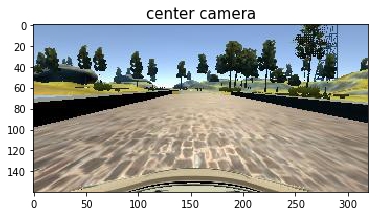

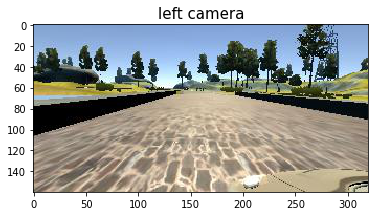

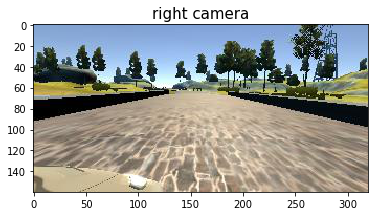

In [12]:
for i in range(3):
    plt.figure()
    t_img = cv2.cvtColor(cv2.imread(dataDir +'IMG/'+samples[i][0]), cv2.COLOR_BGR2RGB)
    plt.imshow(t_img)
    plt.title(samples[i][0].split('_')[0] + ' camera', fontsize=15)
    plt.show()

## Visualize the data distribution

Following code is trying to explore the dataset on which the model is being trained

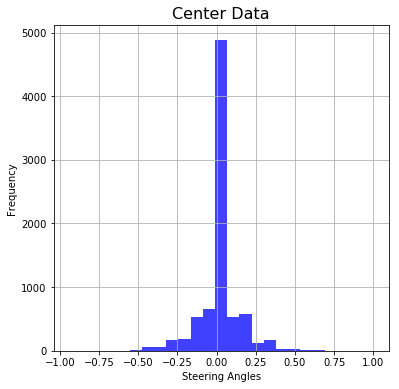

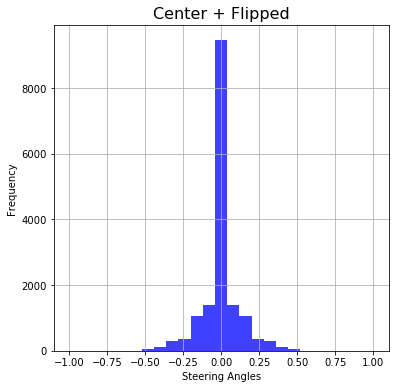

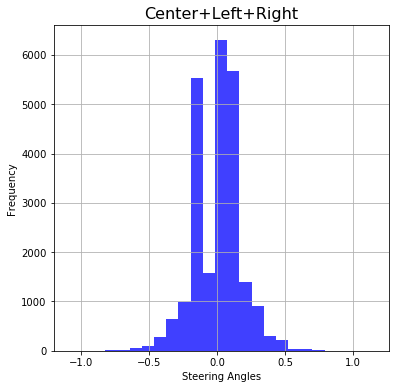

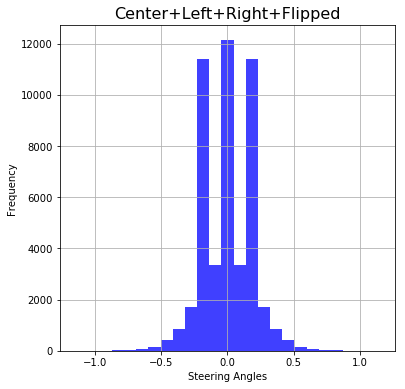

Average number of data points per bin :1928.64


In [13]:
filePath = dataDir+'/driving_log.csv'
lines=getCsvLines(filePath) 
steeringAngles=[]
bins = 25

originalData = []
originalFlippedData = []
originalCLRData = []
originalFlippedCLRData = []
camera_angle_factor = [0,+1,-1]
camera_correction_factor = 0.15

for i_line in lines:        
    # use images from all cameras, center, left and right
    i_angleCenter = float(i_line[3])
    
    originalData.append(i_angleCenter)
    
    for i in range(3):
        #print(i_line)
        # add steering angle according to which camera it came from i.e. center, left or right
        i_angle=i_angleCenter+camera_correction_factor*camera_angle_factor[i]
        
        originalCLRData.append(i_angle)
        originalFlippedCLRData.extend([i_angle,-i_angle])
originalFlippedData.extend(originalData)
originalFlippedData.extend([-i for i in originalData])

#originalFlippedCLRData.extend([i for i in originalCLRData])
#originalFlippedCLRData.extend([-i for i in originalCLRData])
#convert images and steering angles into numpy arrays

for steeringAngles, title in zip([originalData, originalFlippedData, originalCLRData, originalFlippedCLRData],['Center Data', 'Center + Flipped', 'Center+Left+Right', 'Center+Left+Right+Flipped']):
    
    y_train = np.array(steeringAngles)
    plt.figure(figsize=(6,6))
    plt.hist(y_train, bins, facecolor='b', alpha=0.75)
    plt.title(title, fontsize=16)
    plt.xlabel('Steering Angles')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

print('Average number of data points per bin :{}'.format(len(originalFlippedCLRData)/bins))

## Data Distribution Flattening

In all the graphs above, it is clear that the data has huge number of samples of drawing straight (steering angle = 0) or nearly straight. This data will train a model with tendency to drive straight. In order to fix this, I have tried to equalize (in some sense) distribution of samples.

In [6]:
anglesOnly = [i[1] for i in samples]
print(len(anglesOnly))
dataHistogram, numBins = np.histogram(anglesOnly, bins)

print('numBins {}, length = {}'.format( numBins, len(numBins)))
print(dataHistogram, len(dataHistogram))

24108
numBins [-1.0926954  -1.00298758 -0.91327977 -0.82357195 -0.73386414 -0.64415632
 -0.5544485  -0.46474069 -0.37503287 -0.28532506 -0.19561724 -0.10590942
 -0.01620161  0.07350621  0.16321402  0.25292184  0.34262966  0.43233747
  0.52204529  0.6117531   0.70146092  0.79116874  0.88087655  0.97058437
  1.06029218  1.15      ], length = 26
[   4    6    3   10   21   59   96  279  653  988 5535 1585 6299 5669 1397
  900  298  212   45   30    9    5    1    2    2] 25


In following cell, I tried to reduce the number of samples, below average samples per bin (I have taken number of bins to be 25), sot that after training the model would NOT have bias towards drawing straight.

I have divided the whole input data into 25 bins, and counted frequency of each bin. I have computed average number of samples per bin, and I have attempted to remove samples from bins having more than average samples. This is done be computing __ rejectProb __ for each bin, which is calculated as (1-averageSamplesPerBin/( number of samples in that bin)).

Then, I have iterated through all the samples in the bin, generated a randon number between 0 and 1, if that number is greater (i.e. this sample should stay), I have appended it to new list of samples. 

In [7]:
# find out keep probs for each bin
rejectProb= [0.0]*len(dataHistogram)

averageSamplesPerBin = len(anglesOnly)/len(dataHistogram)

print('average Samples per bins : {}'.format(averageSamplesPerBin))

for i in range(len(dataHistogram)):
    if averageSamplesPerBin < dataHistogram[i]:
        rejectProb[i]= 1- averageSamplesPerBin/dataHistogram[i]

print(rejectProb)
newSamples=[]
for i in range(len(anglesOnly)):
    for j in range(len(dataHistogram)):
        if anglesOnly[i] > numBins[j] and anglesOnly[i] <= numBins[j+1]:
            if np.random.rand() > rejectProb[j]:
                newSamples.append(samples[i])

print('Before and after distribution normalization, # of samples: {} and {}'.format(len(samples),len(newSamples)))                
#samples = newSamples

average Samples per bins : 964.32
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023967611336032313, 0.82577777777777772, 0.39159621451104099, 0.84690903317986987, 0.82989592520726763, 0.3097208303507516, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Before and after distribution normalization, # of samples: 24108 and 8381


### Visualization after data flattening

Following graph decpicts distribution of data after data distribution flattening, and it looks much less biased (towards driving straight) compared to earliar graphs/(distirbutions without flattening).

This distribution is far better than un-processed one. It looks asymetric because this distribution uses center, left and right camera image, however NOT their flipped versions. And, samples are based on rejection probability, so some bins must have more than average samples per bin and some must have lower than average samples per bin.

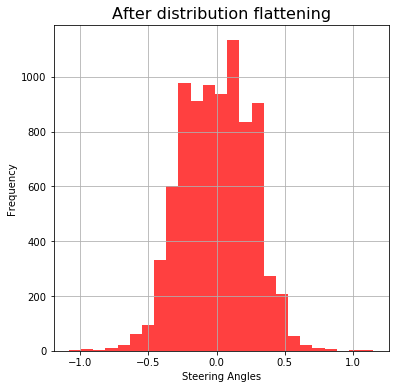

In [8]:
samples=newSamples
y_train = np.array([i[1] for i in samples])
plt.figure(figsize=(6,6))
plt.hist(y_train, bins, facecolor='r', alpha=0.75)
plt.title('After distribution flattening', fontsize=16)
plt.xlabel('Steering Angles')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Training the model

Set parameters like, create a new model or load a model from file, color channels and should the model use flipped images for training and validation.

In [9]:
## Set some parameters
newModel = False
modelFile = './udacityModel.h5'
colorSpace='RGB'
flipImagesLR = False


# Rubric 6:

### Have the model parameters been tuned appropriately?

I have used Adam optimizer, hence learning parameter was chosen automatically adjusted. 
    I used mean squared error for the loss function. The code is in below cell.
    
Following cell also decides, if a new model has to be created or weights from an old model should be loaded.

In [10]:
if newModel:
    print('Creating new model')
    model = smallerNVidiaModel()
#createNVidiaModel()
    model.compile(loss='mse', optimizer='adam')
else:
    print('Using old model from {}'.format(modelFile))
    model = load_model(modelFile)

Creating new model


/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="elu", strides=(2, 2), kernel_regularizer=<keras.reg...)`
/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2), kernel_regularizer=<keras.reg...)`
/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2), kernel_regularizer=<keras.reg...)`
/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu", strides=(1, 1), kernel_regularizer=<keras.reg...)`
/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_laun

In [11]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator      = generator(train_samples,      dataDir, batch_size=32, color_space=colorSpace, useFlipImages=flipImagesLR)
validation_generator = generator(validation_samples, dataDir, batch_size=32, color_space=colorSpace, useFlipImages=flipImagesLR)

saveModelPerEpoch = ModelCheckpoint('udacityModel{epoch:02d}.h5')
numEpochsToTrain=20
history_object=model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=numEpochsToTrain, callbacks=[saveModelPerEpoch])
model.save(modelFile)



/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
  if __name__ == '__main__':
/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=6704, epochs=20, validation_steps=1677)`
  if __name__ == '__main__':


Epoch 1/20
6704/6704 [==============================] - 554s - loss: 0.0612 - val_loss: 0.0387
Epoch 2/20
6704/6704 [==============================] - 547s - loss: 0.0258 - val_loss: 0.0421
Epoch 3/20
6704/6704 [==============================] - 546s - loss: 0.0248 - val_loss: 0.0561
Epoch 4/20
6704/6704 [==============================] - 550s - loss: 0.0260 - val_loss: 0.0420
Epoch 5/20
6704/6704 [==============================] - 550s - loss: 0.0256 - val_loss: 0.0354
Epoch 6/20
6704/6704 [==============================] - 550s - loss: 0.0258 - val_loss: 0.0360
Epoch 7/20
6704/6704 [==============================] - 551s - loss: 0.0251 - val_loss: 0.0337
Epoch 8/20
6704/6704 [==============================] - 550s - loss: 0.0260 - val_loss: 0.0349
Epoch 9/20
6704/6704 [==============================] - 549s - loss: 0.0254 - val_loss: 0.0355
Epoch 10/20
6704/6704 [==============================] - 547s - loss: 0.0264 - val_loss: 0.0349
Epoch 11/20
6704/6704 [==========================

# Rubric 9:

### Is the model architecture documented?

I have attempted to closely follow NVidia model. Same number of layers and kernel sizes for each convolution layer. I have resized the images used to train the model to (200,66) instead of (320,160). I have used _RGB_ channels instead of _YUV_ channels.

Following are the details of each layer. For activation function I have used _ ELU _ throughout. I experimented with drop out, however, finally settled with using L2 reularizer.

 Layer (type)                 Output Shape              Param #   
 
= ================================================================

lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 47, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 22, 48)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
= ================================================================

Total params: 252,219
Trainable params: 252,219
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(model.summary())

## Learning graph

In [ ]:
# plot loss validation and training
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.grid(True)
plt.show()

# Rubric 11:
## Run autonomously in simulator
### Is the car able to navigate correctly on test data?

The car is autonomously driving safely, without any tyre leaving driving area. At no time the car rolls over yellow line or leave driving area of the road or pops onto edges.

I have chosen __ udacityModel12.h5 __ because, it ran with minimum validation loss. By looking at training history, epoch 13 had minimum validation loss, counting from 0, 12th should be the model file hence udacityModel__12__.h5

The [final video](https://youtu.be/YLpbEgAxIP4) is uploaded on YouTube. This video contains successful run of three laps. Why three laps? just to be sure that the model has actually learnt to run on the track, and that its success is not luck.

Uncomment following line to run car autonmously in simulator

In [5]:
%%capture
# Uncomment following line to run car autonmously in simulator
%run -i drive.py udacityModel12.h5 driveAutomatically/

## Create Video from image frames

Uncomment following line to create video of simulator run, from images stored by previous cell. It create __ autonomousDriving.mp4 __ 

In [ ]:
# Uncomment following line to create video of simulator run
#%run -i video.py driveAutomatically/ autonomousDriving

# Discussion

In all the projects, this project was most challenging for me by far. For multiple reasons.
* I didn't have acces to a GPU or a powerfull CPU, to quickly conduct many experiments. I wish had a GPU. (I slightly regret not using AWS GPU instance, maybe I will it later or buy a GPU).
* This project required me to deeply inpect results of each training session, where is the car not driving correctly, where it is going over the edge, which turns are difficult for it to cross and so on. Combined with slow hardware, it was lots work with patience.

My model may fail in following conditions:
* What if there are other vehicles on the road, this model is not trained to handle that.
* The sample data has sunny weather conditions, so it is not trained for snow or rainy or low light conditions.
For the later of the above I would collect more data, and for former I would probably combine it with, vehicle detection algorithm.

Once the model was trained successfully, I was quite relieved to see it working. This project has taught me importance of quality of data.

# Acknowledgements

I found Medium posts by [Jeremy Shannon](https://medium.com/udacity/udacity-self-driving-car-nanodegree-project-3-behavioral-cloning-446461b7c7f9) and [ Aguyen](https://medium.com/@fromtheast/you-dont-need-lots-of-data-udacity-behavioral-cloning-6d2d87316c52) very useful.
And thanks to Udacity's lecture materials for providing data, simulator and very clear explanation of the whole pipeline.